<a href="https://colab.research.google.com/github/chminPark/ml-python/blob/master/%EC%8B%A4%EC%8A%B5_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy
import os
import numpy as np
import random
import time
import os

torch.backends.cudnn.deterministic = True # Use cudnn as deterministic mode for reproducibility
torch.backends.cudnn.benchmark = False

# CIFAR-10 데이터를 이용한다.

In [ ]:
transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4), # Random Crop: Randomly crop the part of the large image and utilize it as an augmented data
        transforms.RandomHorizontalFlip(), # Random Horizontal Flip: Randomly flip the image and utilize it as an augmented data
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]), # Normalize the data using the given mean and standard deviation
        ])

#Apply data preprocessing for test set
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023,0.1994,0.2010]),
        ])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

100%|██████████| 170498071/170498071 [00:02<00:00, 85039321.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
idxs = np.random.choice(len(train_dataset), 10, replace=False)
idxs

array([43141, 40251, 19075, 35432, 30537,  8711, 39109, 12815, 36594,
       44401])

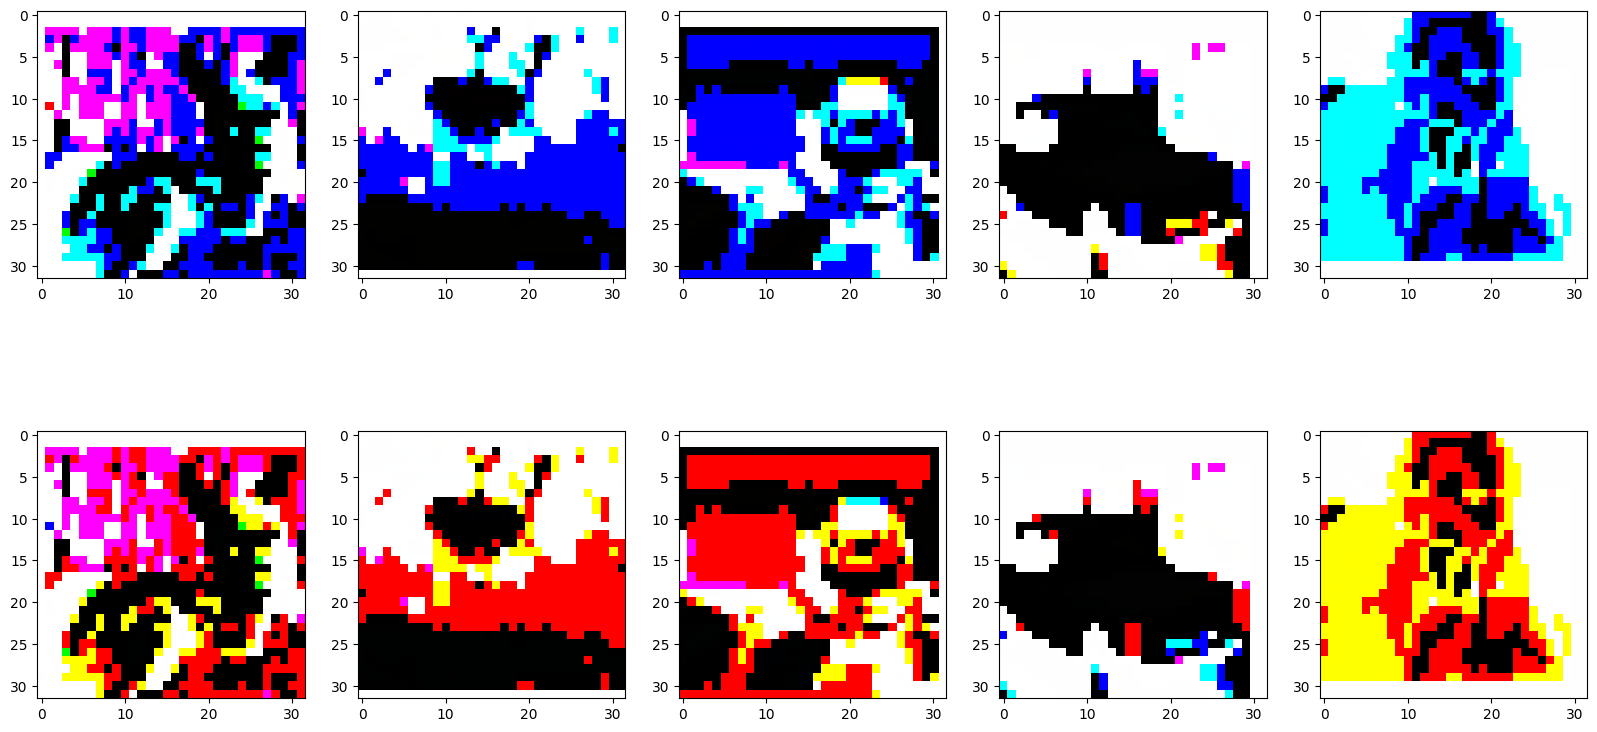

In [ ]:
# Cifar 데이터는 어떻게 생겼을까?
import matplotlib.pyplot as plt
import cv2
import warnings
warnings.filterwarnings("ignore")

num_imgs= 5
idxs = np.random.choice(len(train_dataset), num_imgs, replace=False)

plt.figure(figsize=(20, 10))
for i, idx in enumerate(idxs):

  #### 실습 : Index로 데이터 확인
  #### 1) Tensor to Numpy 2) BGR to RGB
  image, target =  train_dataset[idx]

  # channel을 맨 뒤로 보냄
  image = image.permute(1,2,0).float().numpy()
  image_converted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #########################################

  plt.subplot(2, num_imgs, i+1)
  plt.imshow(image.astype(np.uint8))
  plt.subplot(2, num_imgs, i+num_imgs+1)
  plt.imshow(image_converted.astype(np.uint8))


# VGG구조
![](https://drive.google.com/uc?export=view&id=1I2AYVIxViWv2Rf9Y9tOWeOo-H2bjZo9K)



In [ ]:
class VGG(nn.Module):
    def __init__(self):
      super(VGG, self).__init__()

      ##### 실습 : 위 그림에 있는 CNN구성 요소 선언
      self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same') # Convolutional layer with 3x3 kernel. The size of feature does not change due to the usage of padding.
      self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same')

      self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
      self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding='same')

      self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same')
      self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same')

      self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) #Maxpooling layer to change feature size
      self.avg_pool = nn.AdaptiveAvgPool2d(output_size = (1, 1)) ## 실습: 이미지의 평균값을 계산하는 Layer
      self.fc = nn.Linear(in_features=128, out_features=10) # 실습 : 10개 Class를 만들어 내는 FC

    def forward(self, x):
      #### 실습 : VGG를 구성한다.
      x = self.conv1(x)
      x = F.relu(x)
      x = self.conv2(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv3(x)
      x = F.relu(x)
      x = self.conv4(x)
      x = F.relu(x)
      x = self.max_pool(x)

      x = self.conv5(x)
      x = F.relu(x)
      x = self.conv6(x)
      x = F.relu(x)   # 128x8x8
      x = self.avg_pool(x) # 128x1x1

      x = x.view(-1, 128)
      x = self.fc(x)
      return x

In [ ]:
def reset_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

# 학습함수를 선언하고 학습을 수행한다

In [ ]:
def train(model, data_loader, criterion, optimizer, n_epoch):
  ### 실습 : 학습 중임을 알림
  model.train() ###
  for epoch in range(n_epoch):
    running_loss = 0
    for i, (images, labels) in enumerate(data_loader):
      ### 실습 : 데이터를 GPU로 할당
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      loss = criterion(outputs, labels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      if (i + 1) % 100 == 0:
        print('iteration: [{}/{}]'.format(i + 1, len(data_loader)))

    print('Epoch {}, loss = {:.3f}'.format(epoch + 1, running_loss/len(data_loader)))

In [ ]:
reset_seed(2020)
criterion = nn.CrossEntropyLoss()
##### 실습 : 모델을 GPU에 할당한다.
vgg_model = VGG().to("cuda")

##### Adam 최적화 모델을 할당한다
optimizer = optim.Adam(params=vgg_model.parameters())

train(vgg_model, train_loader, criterion, optimizer, n_epoch=10)

iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 1, loss = 1.757
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 2, loss = 1.336
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 3, loss = 1.110
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 4, loss = 0.982
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 5, loss = 0.893
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 6, loss = 0.813
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 7, loss = 0.746
iteration: [100/500]
iteration: [200/500]
iteration: [300/500]
iteration: [400/500]
iteration: [500/500]
Epoch 

# 평가 함수를 구성하고 평가 정확도를 확인한다

In [ ]:
def eval(model, data_loader):
  #### 실습 : 평가를 위해서는 eval()을 선언
  model.eval()
  total = 0
  correct = 0

  preds = []
  trues = []
  #### 실습 : Gradient를 타지 않아야 한다
  with torch.no_grad():
    for images, labels in data_loader:
      images, labels = images.cuda(), labels.cuda()
      outputs = model(images)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
      preds.append(predicted.detach().cpu().numpy())
      trues.append(labels.detach().cpu().numpy())

    accuracy = 100 * correct / total

  print('Test Accuracy: {}%'.format(accuracy))
  return preds, trues


In [ ]:
len(test_loader)

100

In [ ]:
preds, trues = eval(vgg_model, test_loader)

Test Accuracy: 76.15%


# 각 Class의 정확도는?

In [ ]:
prediction_label = np.stack(preds).flatten()
test_labels = np.stack(trues).flatten()
prediction_label, test_labels

(array([3, 8, 8, ..., 5, 1, 7]), array([3, 8, 8, ..., 5, 1, 7]))

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
from sklearn.metrics import classification_report
print(classification_report(test_labels, prediction_label))

              precision    recall  f1-score   support

           0       0.84      0.75      0.79      1000
           1       0.95      0.82      0.88      1000
           2       0.65      0.70      0.68      1000
           3       0.68      0.49      0.57      1000
           4       0.85      0.61      0.71      1000
           5       0.70      0.70      0.70      1000
           6       0.58      0.93      0.72      1000
           7       0.87      0.79      0.83      1000
           8       0.89      0.87      0.88      1000
           9       0.77      0.95      0.85      1000

    accuracy                           0.76     10000
   macro avg       0.78      0.76      0.76     10000
weighted avg       0.78      0.76      0.76     10000



In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# Accuracy : # 전체 샘플중 맞게 예측한 샘플수 (TP + TN) / Total
from sklearn.metrics import accuracy_score
accuracy_score(test_labels, prediction_label)

0.7615

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# Precision 정밀도 : 예측값 값의 정확도
from sklearn.metrics import precision_score
# 각 label의 prediction을 계산 후 평균을 취함
precision_score(test_labels, prediction_label, average = 'macro')

0.7781025554994233

In [ ]:
########### 실습 : 분류 성능을 평가해 봅니다.
# recall : 실제 Positive중 Positive라고 예측된 비중
from sklearn.metrics import recall_score
recall_score(test_labels, prediction_label, average = 'macro')

0.7615